### PREPARAR AMBIENTE

In [2]:
# pip install psycopg2 pandas
# pip install xgboost

Note: you may need to restart the kernel to use updated packages.


#### PREPARAR LIBRERIAS

In [1]:
import os
import pandas as pd
import psycopg2
from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, skew

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score, r2_score
import numpy as np

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

#### PREPARAR BASE DE DATOS

In [2]:
user = 'avnadmin'
password = 'AVNS_t_c7Hb9Ax6KcW-j3yQK'
host = 'pg-31946569-fernielisvr-3273.i.aivencloud.com'
port = '18209'
database = 'proyecto_final_ml_cd1_uasd'
schema='staging'

engine = create_engine(f'postgresql+psycopg2://{user}:{password}@{host}:{port}/{database}')

### CARGAR DATASOURCE

In [3]:
ruta = 'DATASOURCE/'
files = [f for f in os.listdir(ruta) if os.path.isfile(os.path.join(ruta, f))]

def load_in_database(df, new_table):
    try:
        df.to_sql(
            name=new_table,
            con=engine,
            schema=schema,
            if_exists='replace',
            index=False
        )
        print(f"Tabla '{new_table}' cargada con éxito en el esquema '{schema}'")
    except Exception as e:
        print(f"Error cargando la tabla '{new_table}': {e}")

# Procesar cada archivo
for file in files:
    ruta_completa = os.path.join(ruta, file)
    
    if file.lower().endswith('.xlsx'):
        xls = pd.ExcelFile(ruta_completa)
        for sheet in xls.sheet_names:
            df = pd.read_excel(xls, sheet_name=sheet)
            table_name = f"STG_{sheet.replace(' ', '_').upper()}"
            load_in_database(df, table_name)

    elif file.lower().endswith('.csv'):
        df = pd.read_csv(ruta_completa)
        table_name = f"STG_{file.replace('.csv', '').replace(' ', '_').upper()}"
        load_in_database(df, table_name)

Tabla 'STG_ASSESSS_DETAIL' cargada con éxito en el esquema 'staging'
Tabla 'STG_ASSESS_PLAN' cargada con éxito en el esquema 'staging'
Tabla 'STG_VLE_CLICKSTREAM' cargada con éxito en el esquema 'staging'
Tabla 'STG_CURSOS' cargada con éxito en el esquema 'staging'
Tabla 'STG_STUDENTINFO' cargada con éxito en el esquema 'staging'
Tabla 'STG_VLE_MODULES' cargada con éxito en el esquema 'staging'
Tabla 'STG_REGISTRATION' cargada con éxito en el esquema 'staging'
Tabla 'STG_ASSESSMENTS' cargada con éxito en el esquema 'staging'
Tabla 'STG_COURSES' cargada con éxito en el esquema 'staging'
Tabla 'STG_STUDENTASSESSMENT' cargada con éxito en el esquema 'staging'
Tabla 'STG_STUDENTINFO' cargada con éxito en el esquema 'staging'
Tabla 'STG_STUDENTREGISTRATION' cargada con éxito en el esquema 'staging'


### CARGANDO DATA DE BASE DE DATOS

In [6]:
connection = psycopg2.connect(
    host=host,
    port=port,
    database=database,
    user=user,
    password=password,
    sslmode='require'
)

cursor = connection.cursor()

# Diccionario para guardar dataframes
queries = {
    "df_dim_studentinfo_ord": "SELECT * FROM dwh.vw_dim_studentinfo_ord;",
    "df_reporte_studentinfo_ord": "SELECT * FROM dwh.vw_reporte_studentinfo_ord;",
    "df_studentinfo": "SELECT * FROM dwh.vw_studentinfo;",
    "df_studentinfo_ord": "SELECT * FROM dwh.vw_studentinfo_ord;"
}
dwh_dataframes = {}

try:
    for df_name, query in queries.items():
        print(f"\nEjecutando el query: {df_name}: {query}")
        try:
            cursor.execute(query)
            records = cursor.fetchall()
            if records:
                colnames = [desc[0] for desc in cursor.description]
                dwh_dataframes[df_name] = pd.DataFrame(records, columns=colnames)
                print(f"Datos cargadados correctamente {df_name}. Primeras 5 filas:")
                display(dwh_dataframes[df_name].head())
            else:
                print(f"Del Query {df_name} no se obtuvieron resultados.")
                dwh_dataframes[df_name] = pd.DataFrame()
        except Error as query_error:
            print(f"Error ejecutando el {df_name}: {query_error}")
            dwh_dataframes[df_name] = pd.DataFrame()

except (Exception, Error) as connection_error:
    print(f"Error conectando con la base de datos: {connection_error}")
    for df_name in queries.keys():
        dwh_dataframes[df_name] = pd.DataFrame()


finally:
    # Cerrar la conexión y el cursor
    if cursor:
        cursor.close()
    if connection:
        connection.close()


Ejecutando el query: df_dim_studentinfo_ord: SELECT * FROM dwh.vw_dim_studentinfo_ord;
Datos cargadados correctamente df_dim_studentinfo_ord. Primeras 5 filas:


,columna,secuencia,valor
0,gender,1,F
1,gender,2,M
2,region,1,East Anglian Region
3,region,2,East Midlands Region
4,region,3,Ireland



Ejecutando el query: df_reporte_studentinfo_ord: SELECT * FROM dwh.vw_reporte_studentinfo_ord;
Datos cargadados correctamente df_reporte_studentinfo_ord. Primeras 5 filas:


,id,fecha_carga,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result,ord_gender,ord_region,ord_imd_band,ord_highest_education,ord_final_result,ord_age_band
0,1,2025-07-02,DDD,2013J,3733,M,South Region,HE Qualification,90-100%,55<=,0,60,N,Withdrawn,2,9,11,2,4,3
1,2,2025-07-02,AAA,2014J,6516,M,Scotland,HE Qualification,80-90%,55<=,0,60,N,Pass,2,7,10,2,3,3
2,3,2025-07-02,DDD,2013J,8462,M,London Region,HE Qualification,30-40%,55<=,0,90,N,Withdrawn,2,4,5,2,4,3
3,4,2025-07-02,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass,2,1,11,2,3,3
4,5,2025-07-02,BBB,2013B,23629,F,East Anglian Region,Lower Than A Level,20-30%,0-35,2,60,N,Fail,1,1,4,3,2,1



Ejecutando el query: df_studentinfo: SELECT * FROM dwh.vw_studentinfo;
Datos cargadados correctamente df_studentinfo. Primeras 5 filas:


,id,fecha_carga,code_module,code_presentation,guid_student_id,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,159,2025-07-02,CG0C8,2024J,71098147-CC0D-46B8-8520-D268585D7B02,1,1,1,1,1,,,N,inProgress
1,156,2025-07-02,CG0C8,2024J,CB6C40B9-5885-4F67-B699-2EB65D9780F2,1,1,1,1,1,,,N,inProgress
2,153,2025-07-02,CG0C8,2024J,8B8B6E5E-9A63-4147-99C1-0EB33E8135CE,1,1,1,1,1,,,N,inProgress
3,151,2025-07-02,CG0C8,2024J,DF253687-2C16-42B9-BC82-BAF6E3F72761,1,1,1,1,1,,,N,inProgress
4,144,2025-07-02,CG0C8,2024J,24EE6AD3-0257-4201-A010-FEECEAE6DA55,1,1,1,1,1,,,N,inProgress



Ejecutando el query: df_studentinfo_ord: SELECT * FROM dwh.vw_studentinfo_ord;
Datos cargadados correctamente df_studentinfo_ord. Primeras 5 filas:


,columna,secuencia,valor
0,gender,1,F
1,gender,2,M
2,region,1,Cleveland DSC
3,region,2,Codd RDBMS
4,region,3,Jhon Tukey


### PROCESO EDA

In [7]:
df_dim_studentinfo_ord = dwh_dataframes['df_dim_studentinfo_ord']
df_reporte_studentinfo_ord = dwh_dataframes['df_reporte_studentinfo_ord']
df_studentinfo = dwh_dataframes['df_studentinfo']
df_studentinfo_ord = dwh_dataframes['df_studentinfo_ord']

#### Exploración Inicial 

In [8]:
print('TAMANIO ESTRUCTURA:', df_reporte_studentinfo_ord.shape)
print('\nTIPOS DE DATOS:\n', df_reporte_studentinfo_ord.dtypes)
print('\nNULOS:\n', df_reporte_studentinfo_ord.isnull().sum())

print('\nDEFINICION')
df_reporte_studentinfo_ord.describe()

TAMANIO ESTRUCTURA: (28785, 20)

TIPOS DE DATOS:
 id                        int64
fecha_carga              object
code_module              object
code_presentation        object
id_student               object
gender                   object
region                   object
highest_education        object
imd_band                 object
age_band                 object
num_of_prev_attempts     object
studied_credits          object
disability               object
final_result             object
ord_gender                int64
ord_region                int64
ord_imd_band              int64
ord_highest_education     int64
ord_final_result          int64
ord_age_band              int64
dtype: object

NULOS:
 id                       0
fecha_carga              0
code_module              0
code_presentation        0
id_student               0
gender                   0
region                   0
highest_education        0
imd_band                 0
age_band                 0
num_of_prev_attem

,id,ord_gender,ord_region,ord_imd_band,ord_highest_education,ord_final_result,ord_age_band
count,28785.000000,28785.000000,28785.000000,28785.000000,28785.000000,28785.000000,28785.000000
mean,14393.000000,1.522703,6.874587,6.025430,2.027549,2.888171,1.305124
std,8309.658086,0.499493,3.704637,2.920616,0.979308,0.939362,0.473561
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,7197.000000,1.000000,4.000000,4.000000,1.000000,2.000000,1.000000
50%,14393.000000,2.000000,7.000000,6.000000,2.000000,3.000000,1.000000
75%,21589.000000,2.000000,10.000000,8.000000,3.000000,4.000000,2.000000
max,28785.000000,2.000000,13.000000,11.000000,5.000000,4.000000,3.000000


#### ANALISIS UNIVARIADO

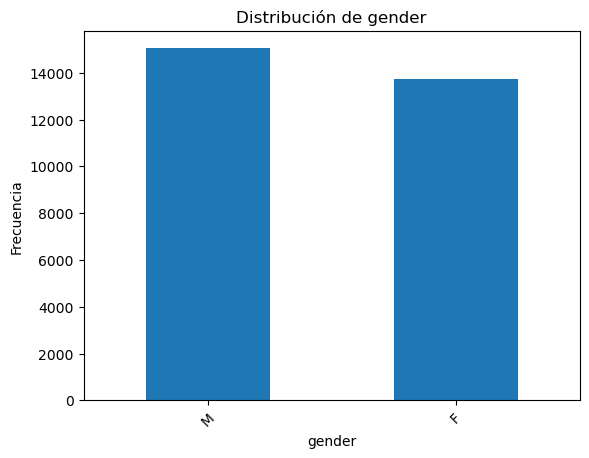

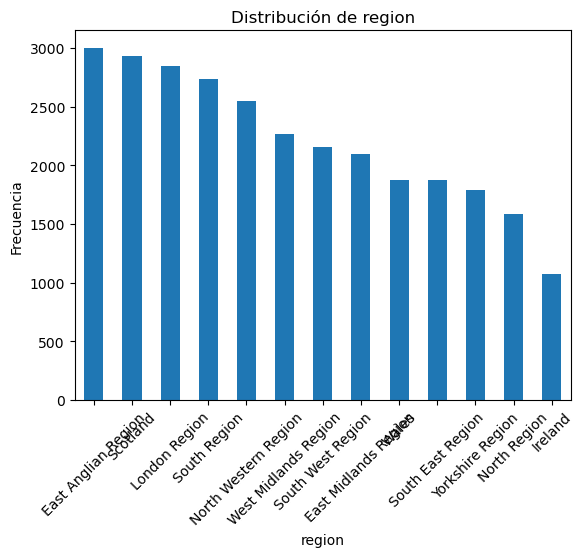

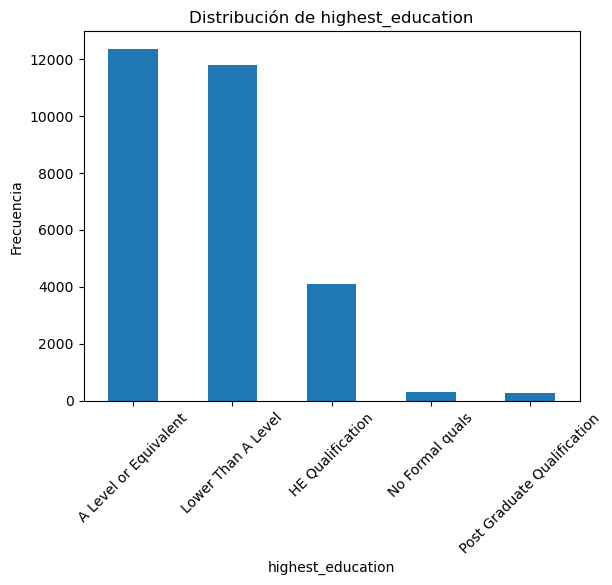

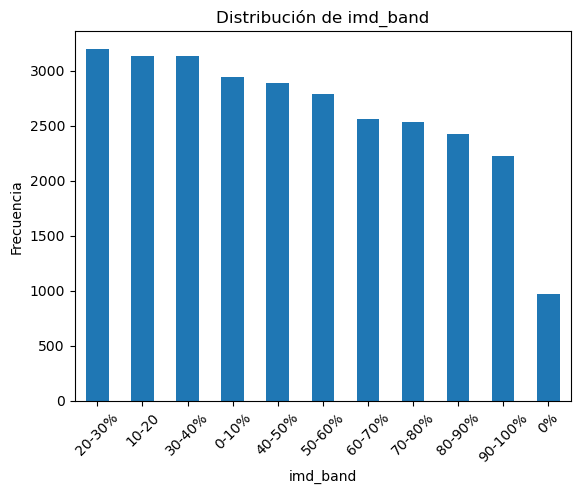

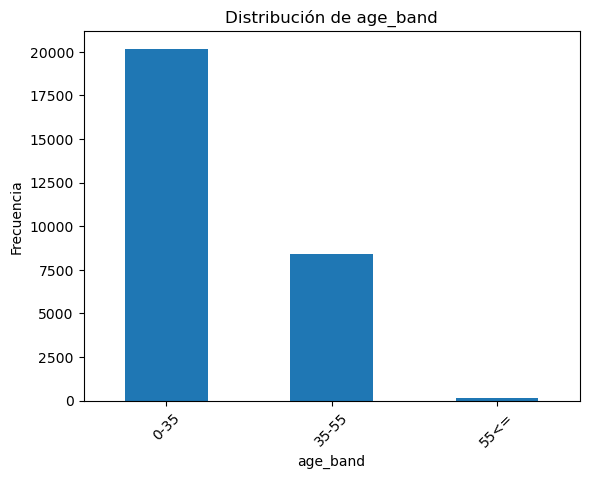

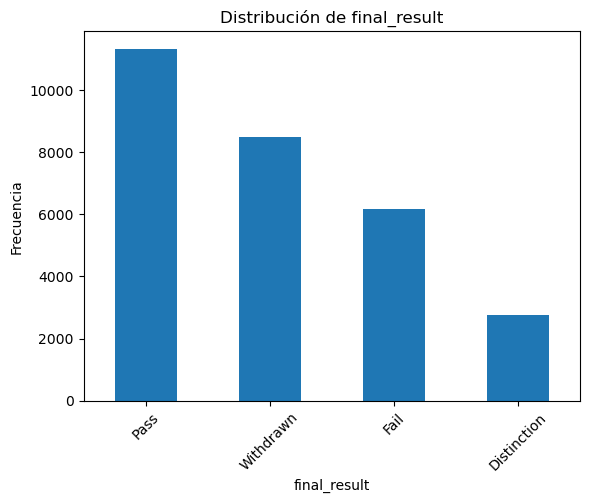

In [9]:
categorical = ['gender', 'region', 'highest_education', 'imd_band', 'age_band', 'final_result']

for col in categorical:
    df_reporte_studentinfo_ord[col].value_counts().plot(kind='bar')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.xticks(rotation=45)
    plt.show()

#### HISTOGRAMA Y DENSIDAD

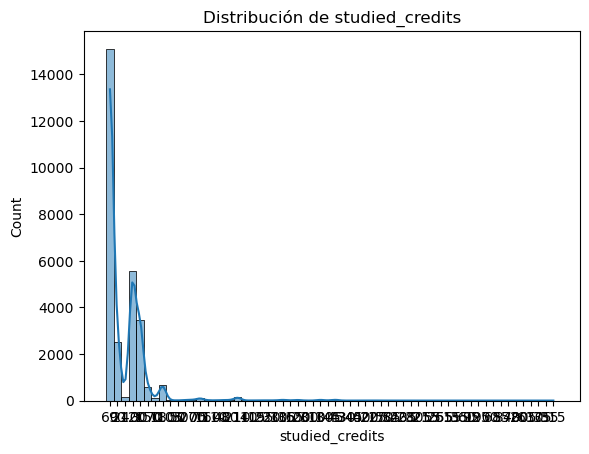

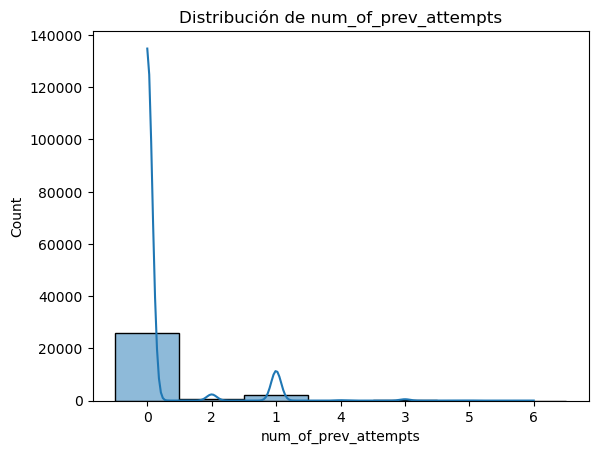

In [11]:
numeric_cols = ['studied_credits', 'num_of_prev_attempts']

for col in numeric_cols:
    sns.histplot(df_reporte_studentinfo_ord[col], kde=True)
    plt.title(f'Distribución de {col}')
    plt.show()

#### KURTOSIS Y SKEWNESS

In [13]:
df_reporte_studentinfo_ord[numeric_cols] = df_reporte_studentinfo_ord[numeric_cols].apply(pd.to_numeric, errors='coerce')
stats = []

for col in numeric_cols:
    col_data = df_reporte_studentinfo_ord[col].dropna()
    k = kurtosis(df_reporte_studentinfo_ord[col], nan_policy='omit')
    s = skew(df_reporte_studentinfo_ord[col], nan_policy='omit')
    stats.append({'columna': col, 'kurtosis': k, 'skew': s})

df_stats = pd.DataFrame(stats)
df_stats

,columna,kurtosis,skew
0,studied_credits,8.668691,1.949403
1,num_of_prev_attempts,26.086156,4.444575


#### IDENTIFICACION DE OUTLIERS

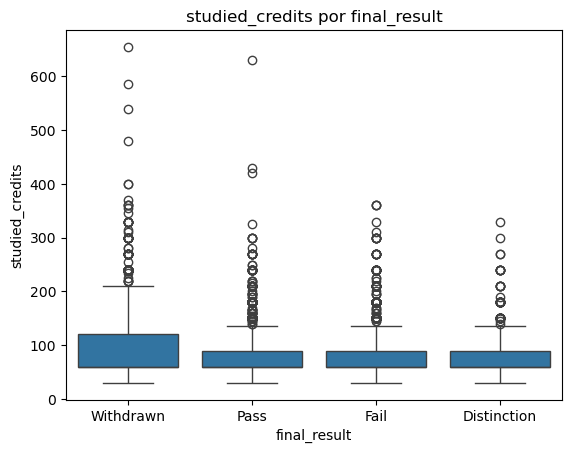

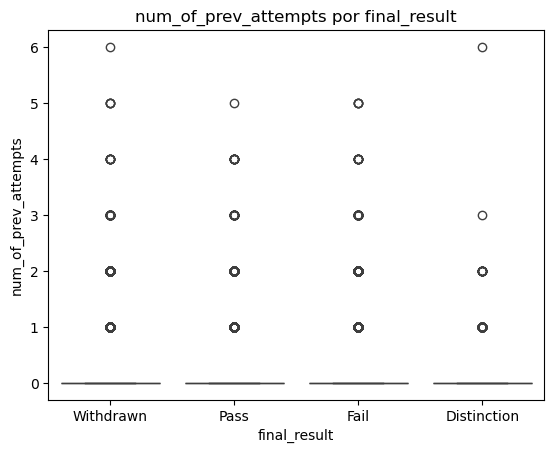

In [15]:
for col in numeric_cols:
    sns.boxplot(x='final_result', y=col, data=df_reporte_studentinfo_ord)
    plt.title(f'{col} por final_result')
    plt.show()

#### ANALISIS BIVARIADO

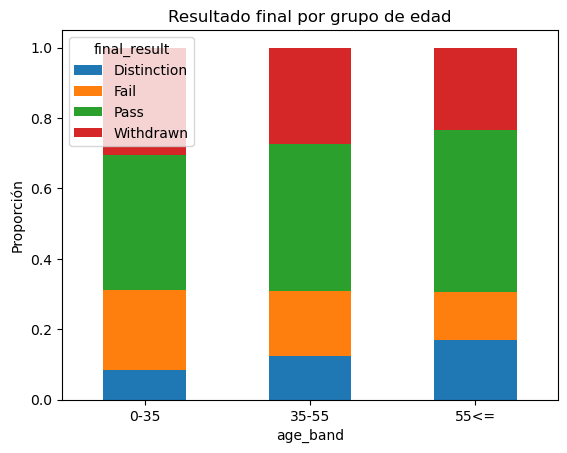

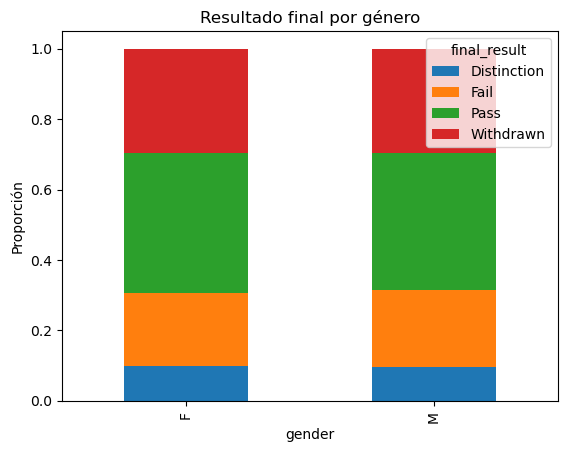

In [17]:
pd.crosstab(df_reporte_studentinfo_ord['age_band'], df_reporte_studentinfo_ord['final_result'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Resultado final por grupo de edad")
plt.ylabel("Proporción")
plt.xticks(rotation=0)
plt.show()

pd.crosstab(df_reporte_studentinfo_ord['gender'], df_reporte_studentinfo_ord['final_result'], normalize='index').plot(kind='bar', stacked=True)
plt.title("Resultado final por género")
plt.ylabel("Proporción")
plt.show()

#### CORRELACION ENTRE ORDINALES

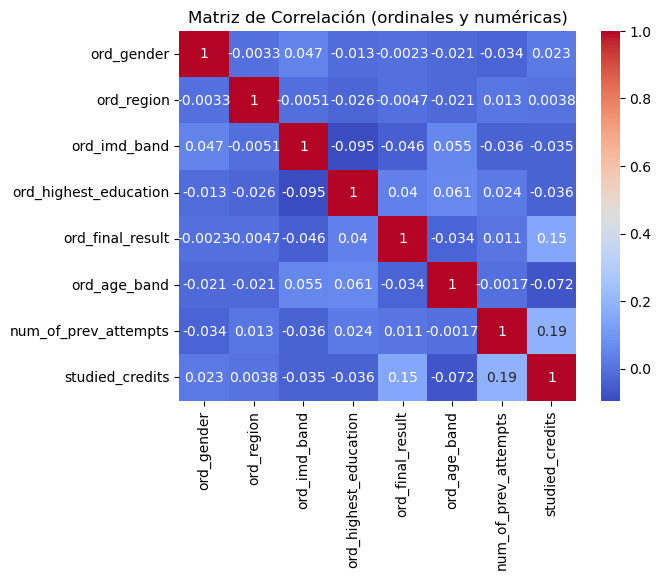

In [19]:
ordinal_cols = ['ord_gender', 'ord_region', 'ord_imd_band', 'ord_highest_education',
                'ord_final_result', 'ord_age_band', 'num_of_prev_attempts', 'studied_credits']

sns.heatmap(df_reporte_studentinfo_ord[ordinal_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Matriz de Correlación (ordinales y numéricas)")
plt.show()

#### DISPERSION

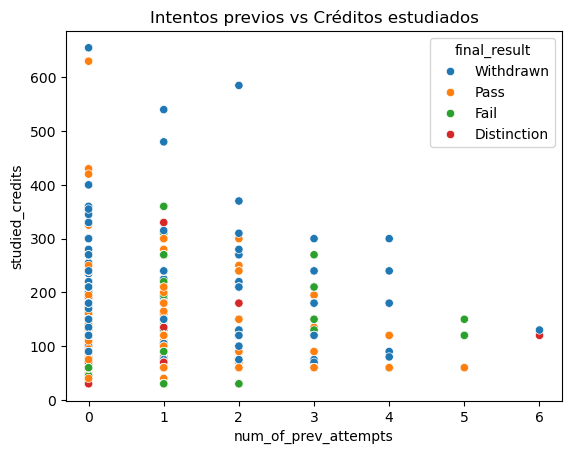

In [21]:
sns.scatterplot(x='num_of_prev_attempts', y='studied_credits', hue='final_result', data=df_reporte_studentinfo_ord)
plt.title('Intentos previos vs Créditos estudiados')
plt.show()

#### MATRIZ DE CONFUSION

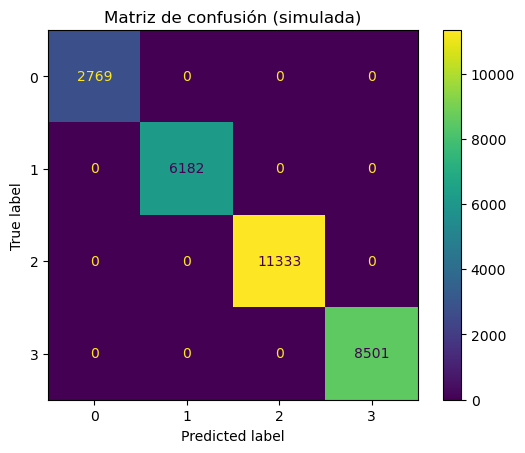

In [23]:
y_test = df_reporte_studentinfo_ord['ord_final_result']
y_pred = df_reporte_studentinfo_ord['ord_final_result']

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Matriz de confusión (simulada)")
plt.show()

#### IMPORTANCIA DE VARIABLES CON RANDOM FOREST

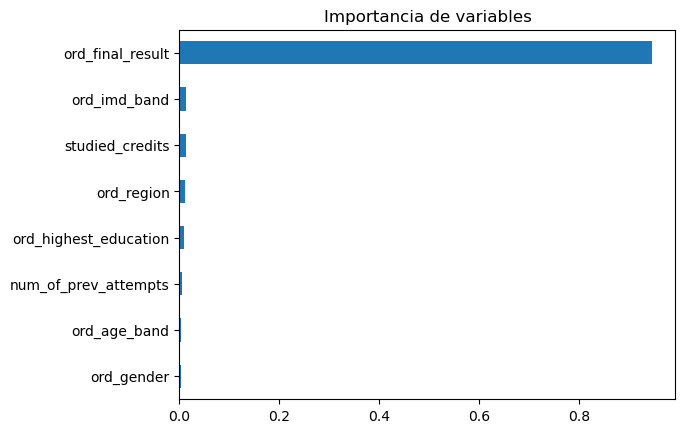

In [25]:
X = df_reporte_studentinfo_ord[ordinal_cols]
y = df_reporte_studentinfo_ord['ord_final_result']

model = RandomForestClassifier()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Importancia de variables')
plt.show()

### ENTRENAMIENTO DE MODELO

#### PREPROCESAMIENTO

In [28]:
df_model = df_reporte_studentinfo_ord.copy()
df_model = df_model.dropna()

# Creamos variable binaria: 'Pass' = 1, resto = 0
df_model['target_bin'] = df_model['final_result'].apply(lambda x: 1 if x == 'Pass' else 0)

# Variables predictoras
features = ['ord_gender', 'ord_region', 'ord_highest_education', 'ord_imd_band',
            'ord_age_band', 'num_of_prev_attempts', 'studied_credits']
X = df_model[features]
y = df_model['target_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### MODELOS SUPERVISADOS PARA VARIABLES DICOTOMICAS

In [30]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results_bin = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_bin[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'roc_auc': roc_auc_score(y_test, y_pred),
        'conf_matrix': confusion_matrix(y_test, y_pred).tolist()
    }

#### REGRESION

In [32]:
from xgboost import XGBRegressor

# Target: studied_credits
y_reg = df_model['studied_credits']

X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.3, random_state=42)

regressors = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor()
}

results_reg = {}

for name, model in regressors.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    results_reg[name] = {
        'mse': mean_squared_error(y_test, y_pred),
        'r2': r2_score(y_test, y_pred)
    }

#### MODELO NO SUPERVISADO

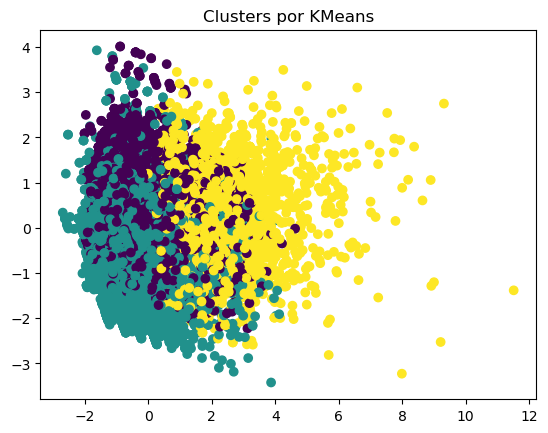

In [34]:

X_scaled = StandardScaler().fit_transform(X)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# Visualización 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)

plt.scatter(pca_components[:, 0], pca_components[:, 1], c=labels, cmap='viridis')
plt.title("Clusters por KMeans")
plt.show()

#### EXPORTANDO RESULTADO DE MODELO

In [36]:
# Resultados clasificación binaria
pd.DataFrame(results_bin).T.to_csv('RESULTADOS/reporte_binarios.csv')

# Resultados regresión
pd.DataFrame(results_reg).T.to_csv('RESULTADOS/reporte_regresion.csv')

#### VIENDO RESULTADO DE MODELO

In [38]:
#ver resultados
binarios_df = pd.read_csv('RESULTADOS/reporte_binarios.csv')
regresion_df = pd.read_csv('RESULTADOS/reporte_regresion.csv')


In [39]:
binarios_df

,Unnamed: 0,accuracy,f1_macro,roc_auc,conf_matrix
0,Logistic Regression,0.602223,0.424537,0.508554,"[[3333, 145], [2145, 134]]"
1,Random Forest,0.562446,0.518790,0.522374,"[[2486, 992], [1527, 752]]"
2,XGBoost,0.595449,0.488342,0.522839,"[[3031, 447], [1882, 397]]"


In [40]:
regresion_df

,Unnamed: 0,mse,r2
0,Linear Regression,7.596796e-27,1.000000
1,Random Forest Regressor,5.928523e-01,0.999636
2,XGBoost Regressor,4.677133e-01,0.999713
